In [1]:
import csv
import numpy as np
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
files = open("./data/par_corp.csv" , encoding='utf-8')

re_lines = []
for line in files:
    if line[0] == '[':
        continue
    re_line = re.sub('{#".?!\n}','', line)
    re_lines.append(re_line)
    
kor = []
eng = []
count = 0
for line in re_lines:
    count = count + 1
    if count % 2 == 0:
        kor.append(line)
    else:
        eng.append(line)

print(kor[:3])
print(eng[:3])

d = {'kor' : kor, 'eng' : eng}
par_corp = pd.DataFrame(d)
print(par_corp)

['#명령은 아래와 같이 반포되었다.\n', '#명령은 반드시 엄격히 준수해야 한다.\n', '#운명의 여신은 용사를 특별히 애호하신다.\n']
['#The order went forth that...\n', '#The orders must be strictly obeyed.\n', '#fortune favors the brave .\n']
                              kor                                            eng
0            #명령은 아래와 같이 반포되었다.\n                #The order went forth that...\n
1         #명령은 반드시 엄격히 준수해야 한다.\n         #The orders must be strictly obeyed.\n
2       #운명의 여신은 용사를 특별히 애호하신다.\n                  #fortune favors the brave .\n
3         #운명에 그가 죽을 것이라고 정해졌다.\n            #Fate destined that he shall die.\n
4      #운명에 그는 목사가 될 것이라고 정해졌다.\n         #Fate had ordained him to die young.\n
...                           ...                                            ...
47662               #사자는 야생동물이다\n                  #The lion is a wild animal.\n
47663            #사자는 황야로 도망갔다.\n  #The lion escaped and returned to the wild.\n
47664   #사자는 우리 안에서 천천히 왔다갔다한다.\n       #The lion paced the floor of its cage.\

In [12]:
encoder_input, decoder_input, decoder_output = [], [], []

for stc in par_corp['kor']:
    encoder_input.append(stc.split())

# start뒤에 띄어쓰기 조심
for stc in par_corp['eng']:
    decoder_input.append(("<start> "+stc).split())

# end앞에 띄어쓰기 조심
for stc in par_corp['eng']:
    decoder_output.append((stc+" <end>").split())

In [13]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[['#명령은', '아래와', '같이', '반포되었다.'], ['#명령은', '반드시', '엄격히', '준수해야', '한다.'], ['#운명의', '여신은', '용사를', '특별히', '애호하신다.']]
[['<start>', '#The', 'order', 'went', 'forth', 'that...'], ['<start>', '#The', 'orders', 'must', 'be', 'strictly', 'obeyed.'], ['<start>', '#fortune', 'favors', 'the', 'brave', '.']]
[['#The', 'order', 'went', 'forth', 'that...', '<end>'], ['#The', 'orders', 'must', 'be', 'strictly', 'obeyed.', '<end>'], ['#fortune', 'favors', 'the', 'brave', '.', '<end>']]


In [17]:
tokenizer_ko = Tokenizer()
tokenizer_ko.fit_on_texts(encoder_input)
encoder_input = tokenizer_ko.texts_to_sequences(encoder_input)

# 1~4999 까지만 인덱싱 변환
tokenizer_en = Tokenizer(5000)
tokenizer_en.fit_on_texts(decoder_input)
tokenizer_en.fit_on_texts(decoder_output)
decoder_input = tokenizer_en.texts_to_sequences(decoder_input)
decoder_output = tokenizer_en.texts_to_sequences(decoder_output)

In [18]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[14650, 1198, 331, 24225], [14650, 66, 7990, 6473, 12], [10413, 24226, 24227, 1199, 24228]]
[[1, 5, 216, 94, 682, 1739], [1, 5, 1062, 75, 27, 2270, 16218], [1, 5746, 8301, 3, 4460, 53]]
[[5, 216, 94, 682, 1739, 2], [5, 1062, 75, 27, 2270, 16218, 2], [5746, 8301, 3, 4460, 53, 2]]


#### 평균길이로 하면 번역과정에서 문장이 짤릴 위험이 있다.

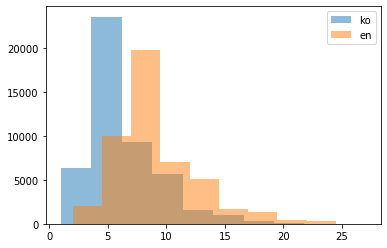

In [21]:
import matplotlib.pyplot as plt

len_ko = []
for data in encoder_input:
    len_ko.append(len(data))
    
len_en = []
for data in decoder_input:
    len_en.append(len(data))
    
plt.hist(len_ko, label='ko', alpha=0.5)
plt.hist(len_en, label='en', alpha=0.5)
plt.legend()
plt.show()

#### 패딩할 때 순서가 중요하기 때문에
#### max_len을 명시를 하지 않는 이유는 알아서 맞춰주기 떄문에

In [22]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_output = pad_sequences(decoder_output, padding='post')

In [23]:
print(encoder_input.shape)
print(decoder_input.shape)

(47667, 27)
(47667, 27)


#### 예측할 때 사용할꺼다. 카테고리 분류 때처럼 인덱스로 해당 카테고리/단어를 찾기 위함

In [24]:
en_to_index = tokenizer_en.word_index
index_to_en = tokenizer_en.index_word

In [28]:
test_size = 12000
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

In [29]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_output_train.shape)

print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_output_test.shape)

(35667, 27)
(35667, 27)
(35667, 27)
(12000, 27)
(12000, 27)
(12000, 27)


In [31]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [34]:
# 문장 길이만 넣고 데이터갯수는 넣지 않을까?
# test데이터를 위해서 model.fit => validation_data 
encoder_inputs = Input(shape=(27, ))

# len(tokenizer_ko.word_index)+1 : 몇개의 임베딩 벡터를 만들지, 뒤에 50은 하이퍼파라미터로 임의로 설정, 
# 패딩때문에, 패딩을 하고나면 0이붙기 때문에 1~4999 단어들이 있고 이후 0이라는 정수값도 포함이 되므로 
encoder_embed = Embedding(len(tokenizer_ko.word_index)+1, 50)(encoder_input)

# 0 (패딩) 같은 임베딩 벡터에서 제외시키겠다.
encoder_mask = Masking(mask_value=0)(encoder_embed)

# 50은 출력차원 
encoder_outputs, h_state, c_state = LSTM(50, return_state=True)(encoder_mask)

In [36]:
decoder_inputs = Input(shape=(27,))
decoder_embed = Embedding(len(tokenizer_en.word_index)+1, 50)(encoder_input)
decoder_mask = Masking(mask_value=0)(decoder_embed)

decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_output,_ ,_ = decider_lstm(decoder_mask, initial_state=[h_state, c_state])

InvalidArgumentError: indices[19211,6] = 38984 is not in [0, 38984) [Op:ResourceGather] name: embedding_1/embedding_lookup/